In [1]:
!ls /kaggle/input/leapgestrecog/leapGestRecog/

00  01	02  03	04  05	06  07	08  09


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D

2024-07-13 06:19:50.565812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 06:19:50.565954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 06:19:50.728371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
Dir = "/kaggle/input/leapgestrecog/leapGestRecog/"

In [4]:
images = []
labels = []
for directory in os.listdir(Dir):
    for subDir in os.listdir(os.path.join(Dir, directory)):
        for img in os.listdir(os.path.join(Dir, directory, subDir)):
            img_path = os.path.join(Dir, directory, subDir, img)
            images.append(img_path)
            labels.append(subDir)

In [5]:
print(images[:5])
print(labels[:5])

['/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0153.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0105.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0018.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0050.png']
['02_l', '02_l', '02_l', '02_l', '02_l']


In [6]:
print(len(images))
print(len(labels))

20000
20000


In [7]:
Iseries = pd.Series(images, name="Images")
Lseries = pd.Series(labels, name="Labels")
hand_gesture_data = pd.concat([Iseries, Lseries], axis=1)
hand_gesture_df = pd.DataFrame(hand_gesture_data)

In [8]:
hand_gesture_df.head()

,Images,Labels
0,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
1,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
2,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
3,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
4,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l


In [9]:
Lseries.value_counts()

Labels
02_l             2000
04_fist_moved    2000
09_c             2000
10_down          2000
06_index         2000
08_palm_moved    2000
07_ok            2000
05_thumb         2000
01_palm          2000
03_fist          2000
Name: count, dtype: int64

In [10]:
hand_gesture_df.shape

(20000, 2)

In [11]:
X_train, X_test = train_test_split(hand_gesture_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(X_train, test_size=0.3, random_state=42)

In [12]:
print(train_set.shape)
print(val_set.shape)
print(X_test.shape)

(11200, 2)
(4800, 2)
(4000, 2)


In [13]:
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=10,
    shuffle=False,
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=10,
    shuffle=False,
)

test = image_gen.flow_from_dataframe(
    dataframe=X_test,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=10,
    shuffle=False,
)

Found 11200 validated image filenames belonging to 10 classes.
Found 4800 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.


In [14]:
classes = list(train.class_indices.keys())
classes

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [15]:
def show_images(image_gen):
    test_dic = test.class_indices
    classes = list(test_dic.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="red", fontsize=16)
        plt.axis("off")
    plt.show()

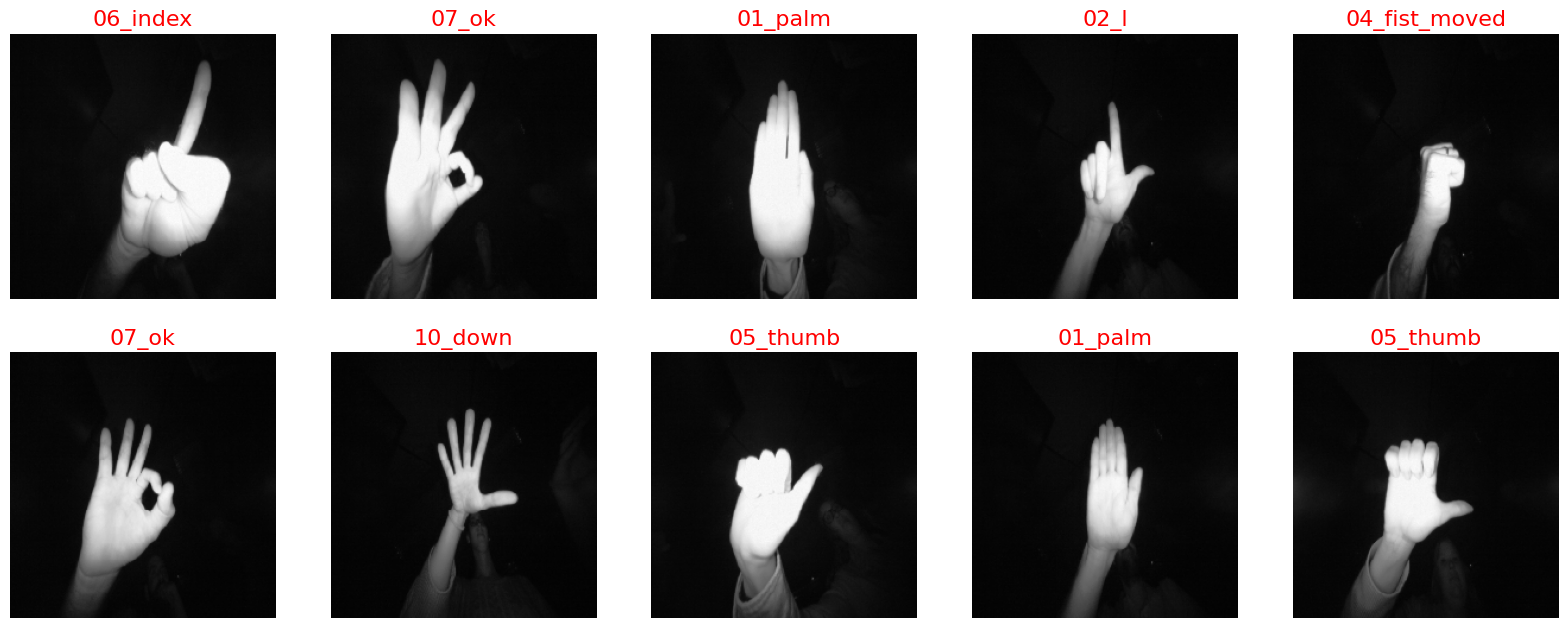

In [16]:
show_images(train)

In [17]:
model = Sequential()

model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(
    Conv2D(
        filters=256,
        kernel_size=(5, 5),
        strides=(1, 1),
        activation="relu",
        padding="same",
    )
)
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(3, 3)))

model.add(
    Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation="relu",
        padding="same",
    )
)
model.add(BatchNormalization())
model.add(
    Conv2D(
        filters=256,
        kernel_size=(1, 1),
        strides=(1, 1),
        activation="relu",
        padding="same",
    )
)
model.add(BatchNormalization())
model.add(
    Conv2D(
        filters=256,
        kernel_size=(1, 1),
        strides=(1, 1),
        activation="relu",
        padding="same",
    )
)
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [18]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.optimizers.SGD(learning_rate=0.0001),
    metrics=["accuracy"],
)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             

 Total params: 13,255,818 (50.57 MB)

 Trainable params: 13,250,442 (50.55 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [20]:
history = model.fit(x=train, validation_data=val, epochs=5, verbose=2)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720851648.724285     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720851648.758455     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720851757.956696     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1120/1120 - 179s - 159ms/step - accuracy: 0.3921 - loss: 2.0345 - val_accuracy: 0.8454 - val_loss: 0.8985
Epoch 2/5
1120/1120 - 76s - 68ms/step - accuracy: 0.8067 - loss: 0.6326 - val_accuracy: 0.9819 - val_loss: 0.1978
Epoch 3/5
1120/1120 - 76s - 68ms/step - accuracy: 0.9139 - loss: 0.3086 - val_accuracy: 0.9904 - val_loss: 0.1062
Epoch 4/5
1120/1120 - 76s - 68ms/step - accuracy: 0.9538 - loss: 0.1855 - val_accuracy: 0.9956 - val_loss: 0.0407
Epoch 5/5
1120/1120 - 76s - 68ms/step - accuracy: 0.9675 - loss: 0.1311 - val_accuracy: 0.9975 - val_loss: 0.0232


In [21]:
model.evaluate(x=test, verbose=1)

  2/400 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 1.0000 - loss: 0.0748

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.9992 - loss: 0.0224


[0.022755298763513565, 0.9984999895095825]

In [22]:
model.save("hand_gesture_model.keras")

# Hand Gesture Recognition Model - (Task - 4)


  6/400 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step

W0000 00:00:1720852528.433306     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step


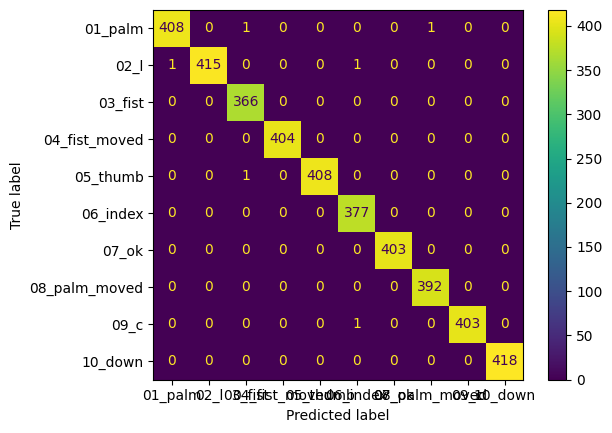

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred = model.predict(test)
pred = np.argmax(pred, axis=-1)

cm = confusion_matrix(y_true=test.classes, y_pred=pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot()